# 1维基百科词条DeepWalk代码实战

In [1]:
# 导入工具包
import networkx as nx
import pandas as pd
import numpy as np

import random
from tqdm import tqdm # 进度条
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

plt.rcParams['font.sans-serif'] = ['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

## 1.1 获取维基百科词条数据
https://densitydesign.github.io/strumentalia-seealsology/
Distance=4
https://en.wikipedia.org/wiki/Computer_vision
https://en.wikipedia.org/wiki/Deeplearning
https://en.wikipedia.org/wiki/Convolutional_netural_network
https://en.wikipedia.org/wiki/Decision_tree
https://en.wikipedia.org/wiki/Support-vector_machine

爬取后下载tsv文件


In [2]:
# 导入数据
df=pd.read_csv('seealsology-data.tsv',sep='\t')
df.head
df.shape

(1337, 3)

## 1.2 图生成

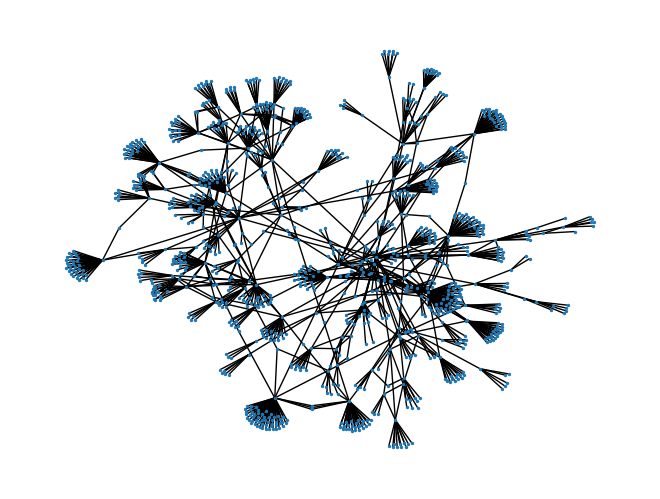

In [3]:
# 生成图并可视化
G=nx.from_pandas_edgelist(df,'source','target',edge_attr=True,create_using=nx.Graph())
len(G)
nx.draw(G,node_size=2)
plt.show()

## 1.3 随机游走

In [4]:
# 生成随机游走序列函数
def get_randomwalk(node,path_length):
    '''
    输入起始节点和路径长度，生成随机游走序列
    '''
    # 随机游走列表
    random_walk=[node]

    for i in range(path_length-1):
        # 获取当前节点的所有邻居
        temp=list(G.neighbors(node))
        # 删去已在游走列表中的点
        temp=list(set(temp)-set(random_walk))
        if len(temp)==0:
            break
        # 随机选取一个节点
        random_node=random.choice(temp)
        random_walk.append(random_node)
        node=random_node
    
    return random_walk

In [5]:
all_nodes=list(G.nodes())
print

<function print>

In [6]:
a=get_randomwalk('constructivist epistemology',3)
print(a)

['constructivist epistemology', 'personal construct psychology']


In [7]:
# 生成随机游走序列
gama = 10 #每个节点作为起始节点生成随机游走序列的个数
walk_length = 5
random_walks = []
for n in tqdm(all_nodes):#进度条
    for i in range(gama):
        random_walks.append(get_randomwalk(n,walk_length))

len(random_walks)


100%|██████████| 1072/1072 [00:00<00:00, 7165.80it/s]


10720

## 1.4 训练DeepWalk模型

In [8]:
#训练Word2Vec模型 训练DeepWalk模型就是Word2Vec模型

from gensim.models import Word2Vec


In [9]:
#sg为skip-gram,hs=0表示不加分层softmax,negative表示负采样
model = Word2Vec(vector_size=256,
                window=4,sg=1,hs=0,negative=10,
                alpha=0.03,min_alpha=0.0007,seed=14)

# 用随机游走构建词汇表
model.build_vocab(random_walks,progress_per=2)

# 训练
model.train(random_walks,total_examples=model.corpus_count,
            epochs=50,report_delay=1)
            

(1677875, 1914700)

In [11]:
# 分析结果

# 查看某个结果的embedding
model.wv.get_vector('decision tree').shape
model.wv.get_vector('decision tree')

array([ 0.39967176,  0.24770425, -0.24914348,  0.7336686 , -0.4011424 ,
       -0.45773202, -0.3391597 ,  0.09981397,  0.23699519, -0.35206926,
        0.04139607,  0.19815859,  0.01663016,  0.3352095 ,  0.2784815 ,
       -0.08032583, -0.22526579, -0.5624177 , -0.03606716, -0.43800506,
       -0.45538023,  0.38580498, -0.58106154,  0.17777728, -0.23823975,
       -0.01500627,  0.12287441, -0.11709596,  0.47412908,  0.02560998,
        0.0888655 , -0.17226583,  0.28856415, -0.29853973, -0.31739274,
       -0.47643337, -0.07476245,  0.49442086, -0.1928406 ,  0.21057788,
        0.3933    , -0.09116656,  0.28809384, -0.01463606,  0.00136848,
        0.18329981, -0.00993431,  0.13077988, -0.04010468,  0.40623003,
        0.2666745 ,  0.3207008 ,  0.07826637,  0.29795575, -0.1756786 ,
       -0.4661243 , -0.01219773, -0.23489484,  0.09017524,  0.7489024 ,
       -0.28406426, -0.2546268 , -0.18136437, -0.2758614 ,  0.13534637,
        0.2867835 ,  0.37060818, -0.08269623, -0.15258919,  0.10

In [12]:
# 找相似词语

model.wv.similar_by_word('decision tree')

[('decision table', 0.8071242570877075),
 ('decision matrix', 0.8004897832870483),
 ('boosting (machine learning)', 0.7998068332672119),
 ('drakon', 0.7931990027427673),
 ('ordinal priority approach', 0.7790057063102722),
 ('decision list', 0.778160810470581),
 ('topological combinatorics', 0.7781341671943665),
 ('truth table', 0.7743435502052307),
 ('markov chain', 0.7703678607940674),
 ('decision cycle', 0.7703321576118469)]

## 1.5 降维可视化
### PCA
可视化全部词条的二维Embedding

In [16]:
x= model.wv.vectors

# 将embedding用PCA降维到二维
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
embed_2d=pca.fit_transform(x)
print(embed_2d)


[[-1.2513212  -1.3334968 ]
 [-1.2164794   1.5826633 ]
 [ 1.5092703   0.1420217 ]
 ...
 [-0.7057405   0.2109205 ]
 [-0.8476928   1.8234308 ]
 [ 0.8951127  -0.33700824]]


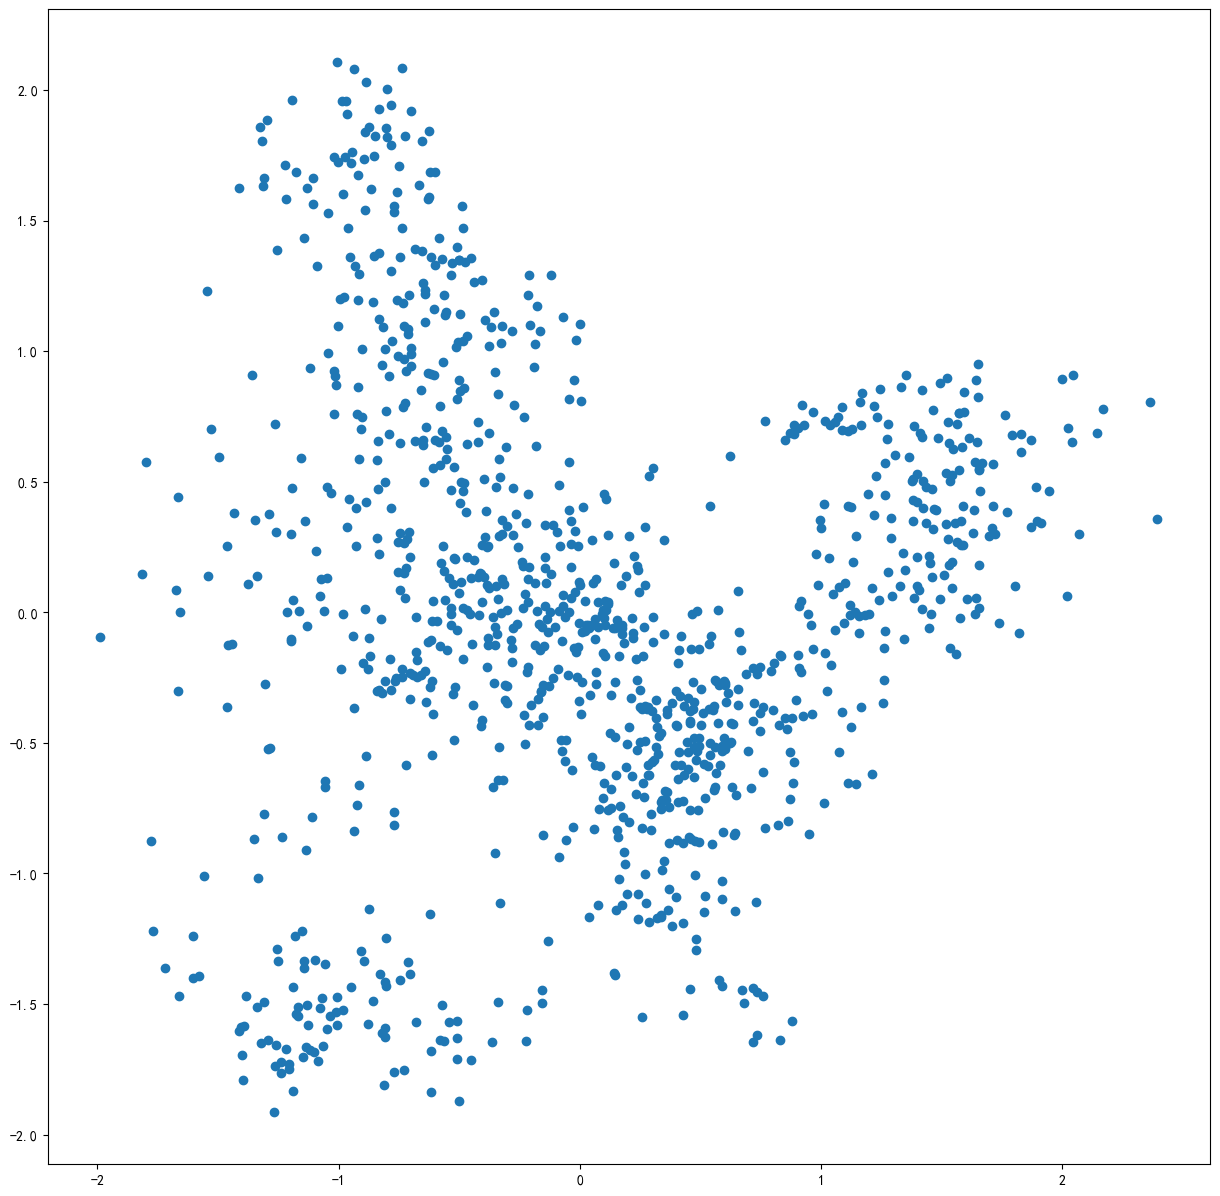

In [18]:
plt.figure(figsize=(15,15))
plt.scatter(embed_2d[:,0],embed_2d[:,1])
plt.show()

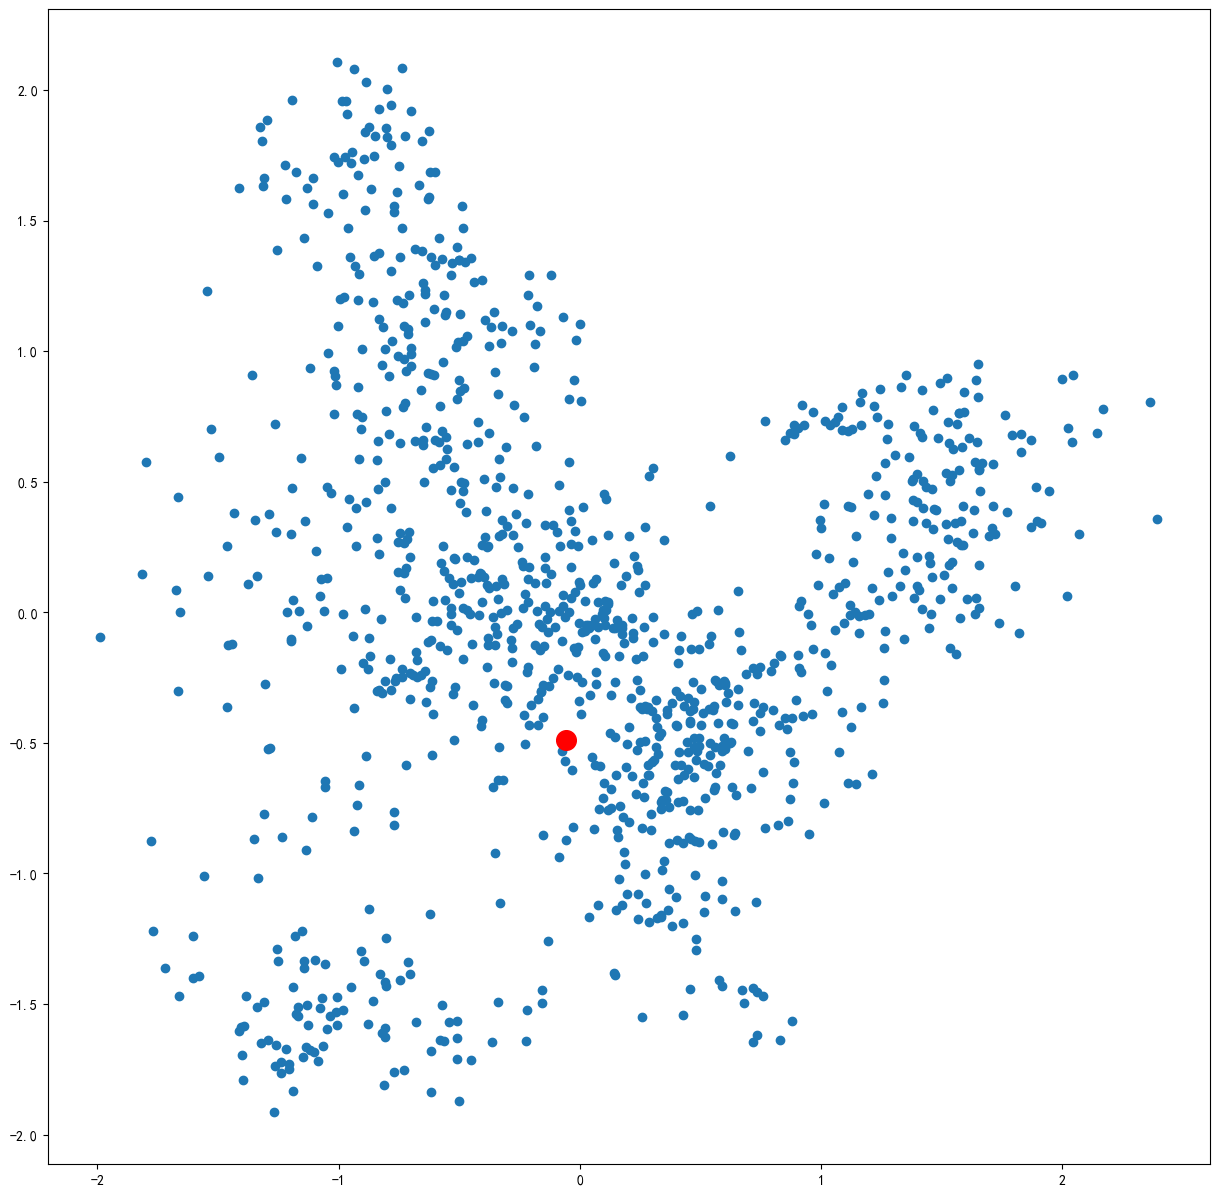

In [24]:
# 可视化某些词条的二维embedding
term= 'computer vision'

term_356d=model.wv[term].reshape(1,-1)

term_2d=pca.transform(term_356d)
plt.figure(figsize=(15,15))
plt.scatter(embed_2d[:,0],embed_2d[:,1])
plt.scatter(term_2d[:,0],term_2d[:,1],c='r',s=200)
plt.show()


['information theory', 'data mining', 'empathy', 'analytics', 'speech recognition software in healthcare', 'embodied cognition', 'induction (philosophy)', 'turing test', 'perception', 'social network analysis', 'simulated reality', 'scientific perspectivism', 'space mapping', 'social complexity', 'theory of mind', 'black box', 'intentional stance', 'origin of language', 'eliminative materialism', 'decision tree', 'big data', 'quantum mind', 'racial profiling', 'constructivist epistemology', 'pattern recognition', 'predictive analytics', 'crime mapping', 'surrogate model', 'computer vision', 'cetacean intelligence']


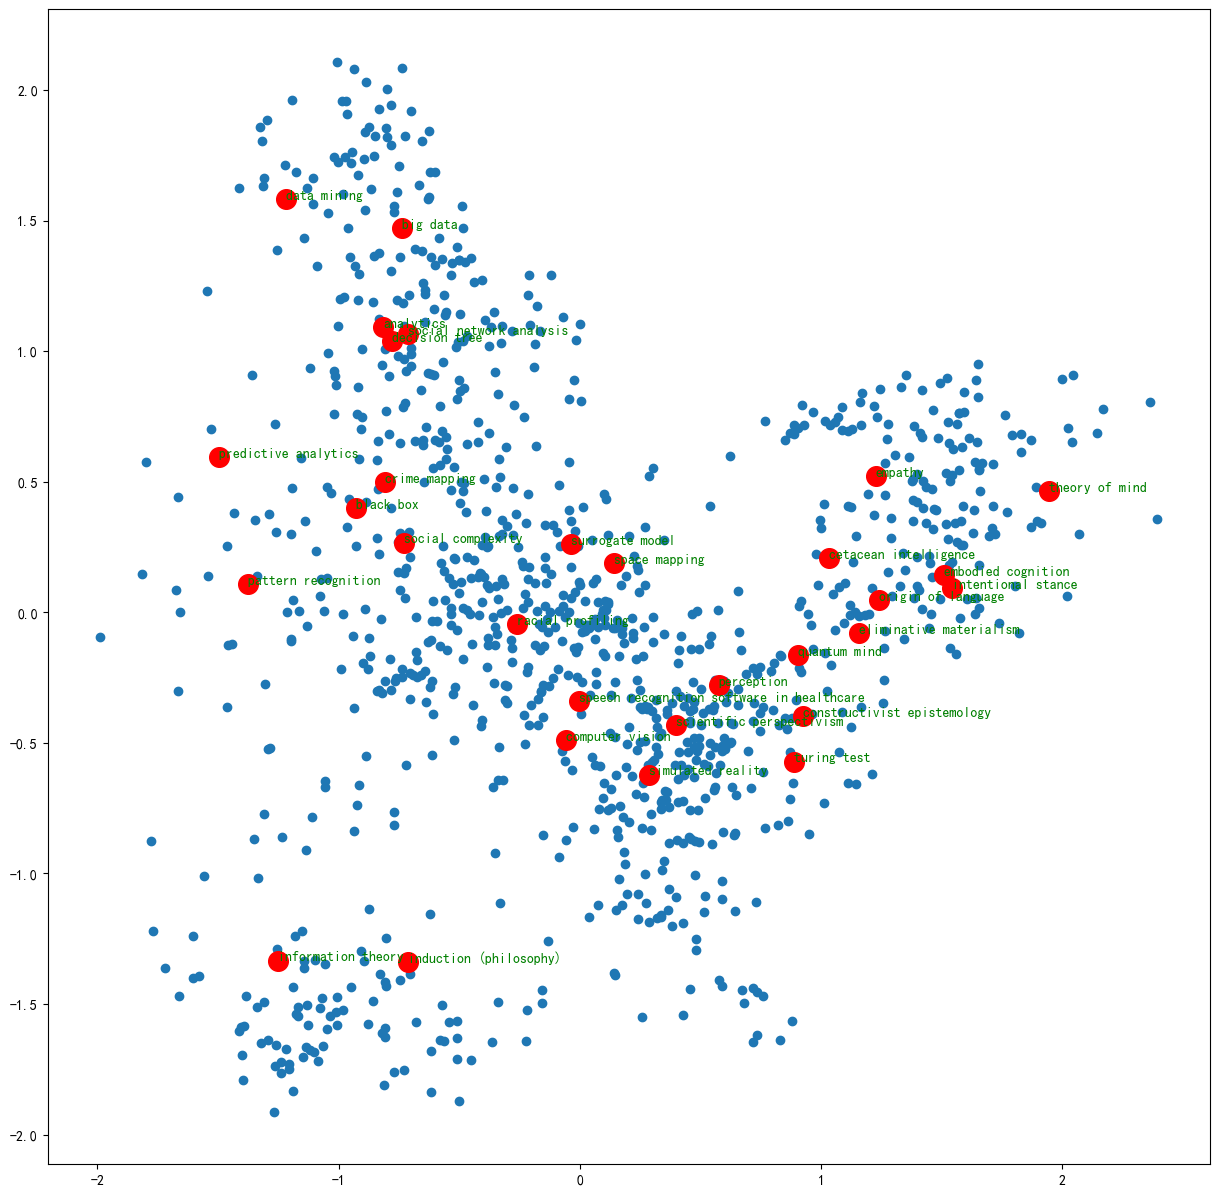

In [33]:
# 计算pagerank重要度
pagerank=nx.pagerank(G)
node_importance=sorted(pagerank.items(),key=lambda x:x[1], reverse=True)

#取最高的前n个节点
n=30
term_chosen=[]
for each in node_importance[:n]:
    term_chosen.append(each[0])
print(term_chosen)
term2index=model.wv.key_to_index

plt.figure(figsize=(15,15))
plt.scatter(embed_2d[:,0],embed_2d[:,1])
for i in term_chosen:
    ind=term2index[i]
    plt.scatter(embed_2d[ind,0],embed_2d[ind,1],c='r',s=200)
    plt.annotate(i,xy=(embed_2d[ind,0],embed_2d[ind,1]),c='g',fontsize=10)

plt.show()


D:\APP\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\APP\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


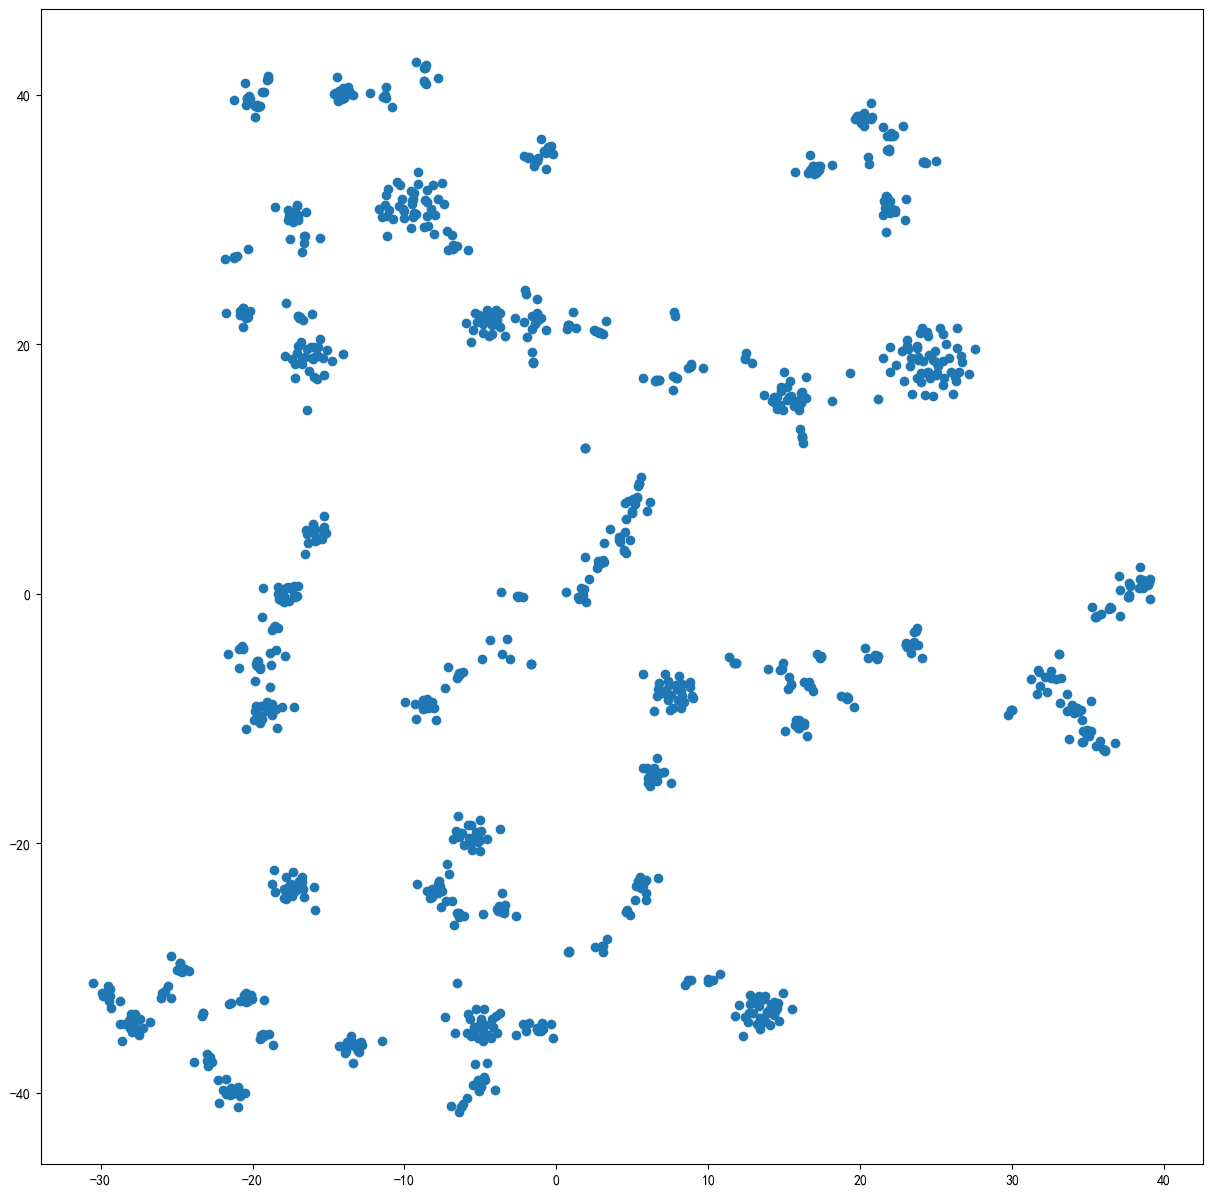

In [35]:
### TSNE降维可视化
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,n_iter=1000)
em_2d=tsne.fit_transform(x)
plt.figure(figsize=(15,15))
plt.scatter(em_2d[:,0],em_2d[:,1])
plt.show()

# 2 Node2Vec代码实战
悲惨世界人物关系图

In [1]:
# 导入工具包
import networkx as nx
import pandas as pd
import numpy as np

import random
import matplotlib.pyplot as plt
import node2vec
from node2vec import Node2Vec
plt.rcParams['font.sans-serif'] = ['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

## 2.1 生成图并训练模型

In [3]:
#G = nx.karate_club_graph()
G=nx.les_miserables_graph()
node2vec=Node2Vec(G,
                dimensions=32,#嵌入维度
                p=2,
                q=0.5,
                walk_length=3,
                num_walks=600,#每个节点作为起始节点生成的随机游走个数
                workers=4)#并行线程数

model=node2vec.fit(window=3,#skip-gram窗口大小
                    min_count=1,#忽略出现次数低于此阈值的点
                    batch_words=4)#每个线程处理的数据量
a=model.wv.vectors

Computing transition probabilities: 100%|██████████| 77/77 [00:00<00:00, 1715.60it/s]


## 2.2 节点embedding聚类可视化

In [4]:
# 聚类
from sklearn.cluster import KMeans
cluster_labels=KMeans(n_clusters=5).fit(a).labels_
print(cluster_labels)

[2 0 2 4 1 2 3 1 2 1 0 2 2 1 0 1 4 2 4 1 4 1 3 3 3 3 2 2 1 3 3 4 1 3 4 2 2
 2 1 2 3 4 1 1 4 1 1 4 0 2 2 4 1 2 3 1 2 2 0 0 0 0 1 0 0 3 2 2 4 2 2 2 2 2
 4 2 2]


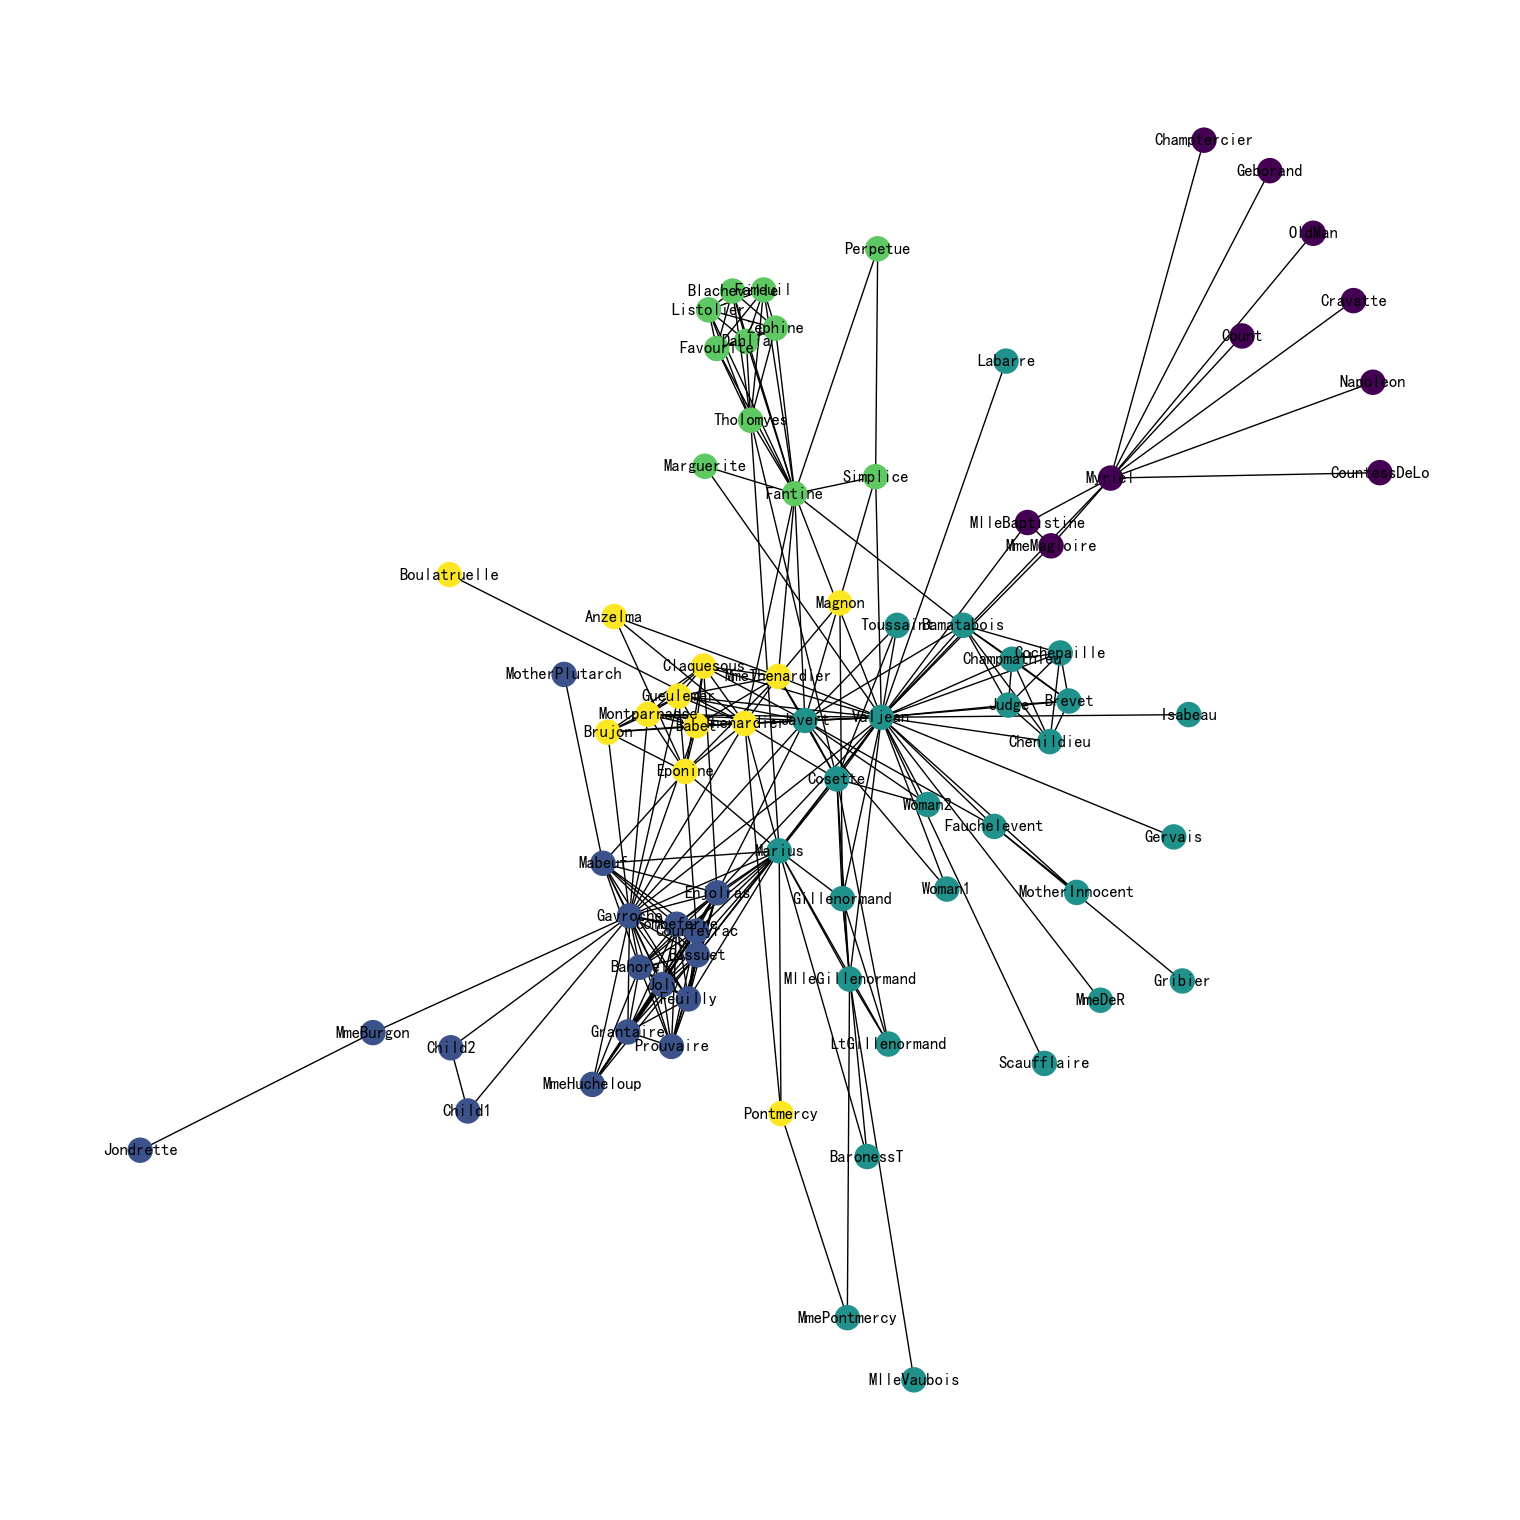

In [5]:
# 将networkx中的节点和词向量中的节点对应
colors=[]
nodes=list(G.nodes)
for node in nodes:
    ind=model.wv.key_to_index[str(node)]#获取这个节点在embedding中的索引
    colors.append(cluster_labels[ind])#获取这个节点的聚类结果

plt.figure(figsize=(15,15))
pos=nx.spring_layout(G,seed=10)
nx.draw(G,pos,node_color=colors,with_labels=True)
plt.show()


## 2.3 节点embedding降维可视化

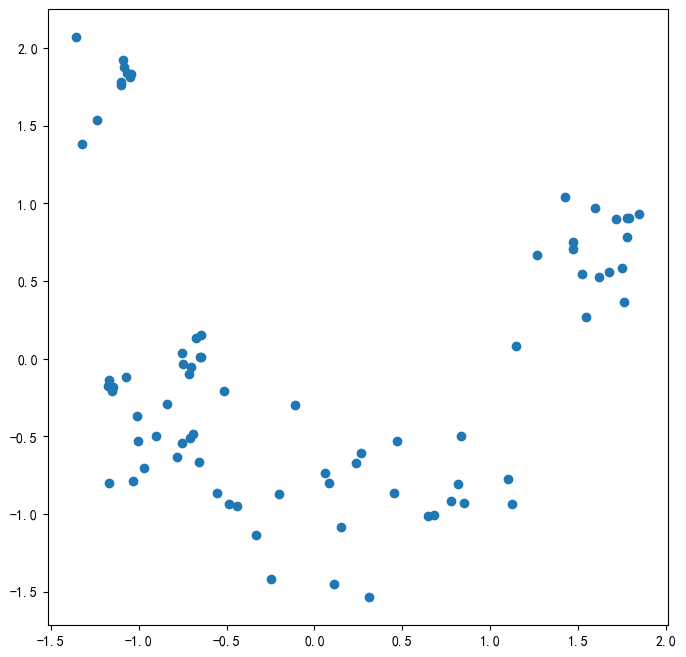

In [9]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
embedd_2d=pca.fit_transform(a)

plt.figure(figsize=(8,8))
plt.scatter(embedd_2d[:,0],embedd_2d[:,1])
plt.show()

In [10]:
model.wv.get_vector('Napoleon').shape
model.wv.most_similar('Napoleon')#相似节点
model.wv.similar_by_word('Napoleon')#相似节点
model.wv.similarity('Napoleon','Brujon')

0.23918217

## 2.4 扩展到连接embedding

In [14]:
from node2vec.edges import HadamardEmbedder
# 两个对应元素相乘
edge_embed=HadamardEmbedder(keyed_vectors=model.wv)


#查看两个节点之间的连接embedding
print(edge_embed[('Napoleon','Brujon')])

#计算所有edge的embedding
edges_kv=edge_embed.as_keyed_vectors()

# 查看('Napoleon','Brujon')连接相似的节点对
edges_kv.most_similar(str(('Napoleon','Napoleon')))

[ 0.03118416  0.5821024   0.92158157  0.35848978 -0.00673259 -0.01025604
  0.46686244 -0.04241694 -0.288162   -0.02754494 -0.2880656  -0.12882465
 -0.09130224 -0.04637657  0.35378015 -0.1062592   0.00378217  0.16439955
  0.02037802  0.04589664  0.40609086 -0.16495101  0.954287    0.0670057
 -0.00863956  0.01782702  0.04981236 -0.68132234  0.00875201  0.08169562
 -0.07549184 -0.3517785 ]


Generating edge features: 100%|██████████| 3003/3003.0 [00:00<00:00, 100319.34it/s]


[("('Geborand', 'Napoleon')", 0.9993472099304199),
 ("('Champtercier', 'Napoleon')", 0.9992651343345642),
 ("('CountessDeLo', 'Napoleon')", 0.9990493059158325),
 ("('Count', 'Napoleon')", 0.9989753365516663),
 ("('Napoleon', 'OldMan')", 0.9988507032394409),
 ("('Cravatte', 'Napoleon')", 0.9986540675163269),
 ("('Champtercier', 'Geborand')", 0.9979687929153442),
 ("('CountessDeLo', 'Geborand')", 0.9976314306259155),
 ("('Count', 'CountessDeLo')", 0.9975605607032776),
 ("('Champtercier', 'CountessDeLo')", 0.9975336790084839)]